## Compare LightGBM in the case of binary class (Sell, Buy)

In [1]:
import os
import sys
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np

# in jupyter (lab / notebook), based on notebook path
module_path = str(Path.cwd().parents[0] / "src")


if module_path not in sys.path:
    sys.path.append(module_path)
import optuna
import pandas as pd
import lightgbm as lgb
from sklearn.impute import SimpleImputer

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from utility_functions import (
    plot_feature_imp,
    plot_strategy,
    backtest_strategy,
    display_report,
    objective_lightgbm,
    select_threshold,
)

In [2]:
METRIC = "precision"
TEST_SIZE = 400
FPR_MAX = 0.05
TIMEOUT = 600

In [3]:
spy = pd.read_csv("../data/raw/spy.csv", parse_dates=True, index_col=0)

In [4]:
target = pd.read_csv("../data/processed/target_df.csv", parse_dates=True, index_col=0)[
    "target"
]

In [5]:
ml_df = pd.read_csv("../data/processed/ml_df.csv", parse_dates=True, index_col=0)

In [6]:
wk_df = pd.read_csv("../data/processed/exp_price.csv", parse_dates=True, index_col=0)

In [7]:
interest_rate = wk_df["r"].values

## Baseline LightGBM Classifier without new data

In [8]:
orig_df = ml_df[
    [
        "UNDERLYING_LAST",
        "STRIKE",
        "C_LAST",
        "C_BID",
        "C_ASK",
        "C_IV",
        "C_VOLUME",
        "diff_date",
    ]
].copy()

In [9]:
# orig_df["r"] = interest_rate

### Split dataset

In [10]:
X_train, X_test, y_train, y_test = train_test_split(
    orig_df,
    target.values.flatten(),
    test_size=TEST_SIZE,
    random_state=1968,
    shuffle=False,
)

### Hyper-parameters tuning using Optuna

In [11]:
# Set hash seed for reproducibility
hashseed = os.getenv("PYTHONHASHSEED")
os.environ["PYTHONHASHSEED"] = "0"
study = optuna.create_study(
    direction="maximize",
    sampler=optuna.samplers.TPESampler(seed=1968, n_startup_trials=0),
)
study.optimize(
    lambda trial: objective_lightgbm(trial, X_train, y_train, METRIC),
    n_trials=150,
    timeout=TIMEOUT,
)

print("Number of finished trials: {}".format(len(study.trials)))

print("Best trial:")
trial = study.best_trial

print("  Value: {}".format(trial.value))

print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))
# Restore hash seed
if hashseed is not None:
    os.environ["PYTHONHASHSEED"] = hashseed

[I 2024-02-14 20:05:05,795] A new study created in memory with name: no-name-22568a7e-6fd6-4d62-bfb7-d59af3e08cbf


[I 2024-02-14 20:05:08,490] Trial 0 finished with value: 0.6516209716891358 and parameters: {'lambda_l1': 7.404718208036244e-05, 'lambda_l2': 0.0017734167489736213, 'num_leaves': 242, 'feature_fraction': 0.5157500776564684, 'bagging_fraction': 0.9559495145396355, 'bagging_freq': 5, 'min_child_samples': 30}. Best is trial 0 with value: 0.6516209716891358.
[I 2024-02-14 20:05:09,761] Trial 1 finished with value: 0.6613259597773 and parameters: {'lambda_l1': 4.4622527237644664e-05, 'lambda_l2': 0.001522988392116389, 'num_leaves': 243, 'feature_fraction': 0.4941731326532077, 'bagging_fraction': 0.9532107188094674, 'bagging_freq': 5, 'min_child_samples': 26}. Best is trial 1 with value: 0.6613259597773.
[I 2024-02-14 20:05:10,234] Trial 2 finished with value: 0.6665749827075087 and parameters: {'lambda_l1': 3.935812964529853e-08, 'lambda_l2': 6.940568812421573e-08, 'num_leaves': 21, 'feature_fraction': 0.4213752158570198, 'bagging_fraction': 0.8894514372980655, 'bagging_freq': 2, 'min_child

Number of finished trials: 150
Best trial:
  Value: 0.6743993435237251
  Params: 
    lambda_l1: 5.630023497062174e-08
    lambda_l2: 2.4455778047952212e-08
    num_leaves: 173
    feature_fraction: 0.6559440597490198
    bagging_fraction: 0.759931185953024
    bagging_freq: 1
    min_child_samples: 23


In [12]:
pipe = Pipeline(
    [
        ("imputer", SimpleImputer(strategy="constant", fill_value=0.0)),
        (
            "clf",
            lgb.LGBMClassifier(
                **trial.params
                | {
                    "random_state": 1968,
                    "objective": "binary",
                    "metric": "average_precision",
                    "verbosity": -1,
                    "boosting_type": "gbdt",
                }
            ),
        ),
    ]
)

In [13]:
# Fit the tuned model
pipe.fit(X_train, y_train)

Pipeline(steps=[('imputer', SimpleImputer(fill_value=0.0, strategy='constant')),
                ('clf',
                 LGBMClassifier(bagging_fraction=0.759931185953024,
                                bagging_freq=1,
                                feature_fraction=0.6559440597490198,
                                lambda_l1=5.630023497062174e-08,
                                lambda_l2=2.4455778047952212e-08,
                                metric='average_precision',
                                min_child_samples=23, num_leaves=173,
                                objective='binary', random_state=1968,
                                verbosity=-1))])

In [14]:
# In-sample score
pipe.score(X_train, y_train)

0.9572243346007605

In [15]:
# Best threshold given a 5% of maximum false positive rate
threshold = select_threshold(
    pipe.predict_proba(X_train)[:, 1], y_train, fpr_max=FPR_MAX
)
print(f"Best threshold: {threshold:.2f}")

Best threshold: 0.51


In [16]:
# Use the threshold to make predictions
predictions = np.where(pipe.predict_proba(X_test)[:, 1] >= threshold, 1, 0)

In [17]:
pipe.score(X_test, y_test)

0.5025

              precision    recall  f1-score   support

           0       0.77      0.23      0.35       236
           1       0.45      0.90      0.60       164

    accuracy                           0.51       400
   macro avg       0.61      0.57      0.48       400
weighted avg       0.64      0.51      0.45       400



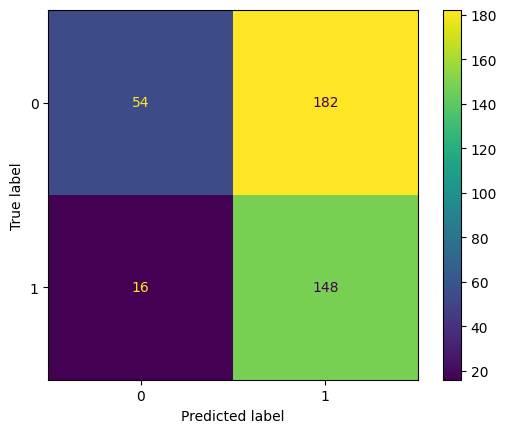

In [18]:
display_report(y_test, predictions)

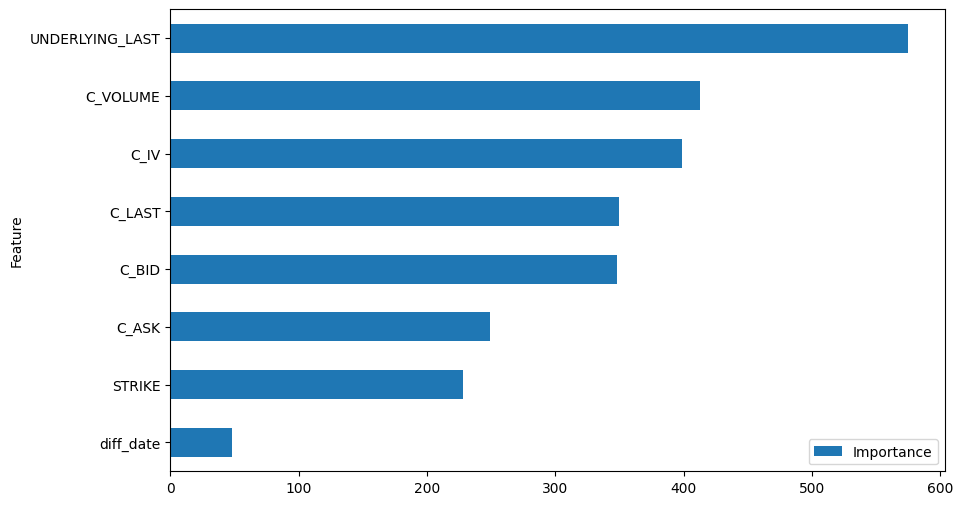

In [19]:
coefficients = pipe.named_steps["clf"].feature_importances_
columns = orig_df.columns
plot_feature_imp(coefficients, columns)

In [20]:
compare_df = pd.DataFrame(predictions, columns=["bare_rf_pred_out"])

### Backtesting

In [21]:
strategy_df = backtest_strategy(predictions, X_test, spy, ml_df)

In [22]:
strategy_df

,strategy,strike,call_price,exp_date,final_price,profit,bare,cum_profit,cum_bare
Date,,,,,,,,,
2022-03-14,1,416.0,11.15,2022-04-04,456.799988,29.649988,29.649988,29.649988,29.649988
2022-03-15,1,426.0,9.43,2022-04-04,456.799988,21.369988,21.369988,51.019976,51.019976
2022-03-16,0,436.0,7.90,2022-04-06,446.519989,0.000000,2.619989,51.019976,53.639965
2022-03-17,0,440.0,7.72,2022-04-06,446.519989,0.000000,-1.200011,51.019976,52.439954
2022-03-18,0,444.0,8.93,2022-04-08,447.570007,0.000000,-5.359993,51.019976,47.079961
...,...,...,...,...,...,...,...,...,...
2023-12-21,0,473.0,6.07,2024-01-12,476.679993,0.000000,-2.390007,264.379878,61.179850
2023-12-22,0,474.0,5.70,2024-01-12,476.679993,0.000000,-3.020007,264.379878,58.159843
2023-12-27,0,476.0,6.19,2024-01-19,482.429993,0.000000,0.239993,264.379878,58.399835


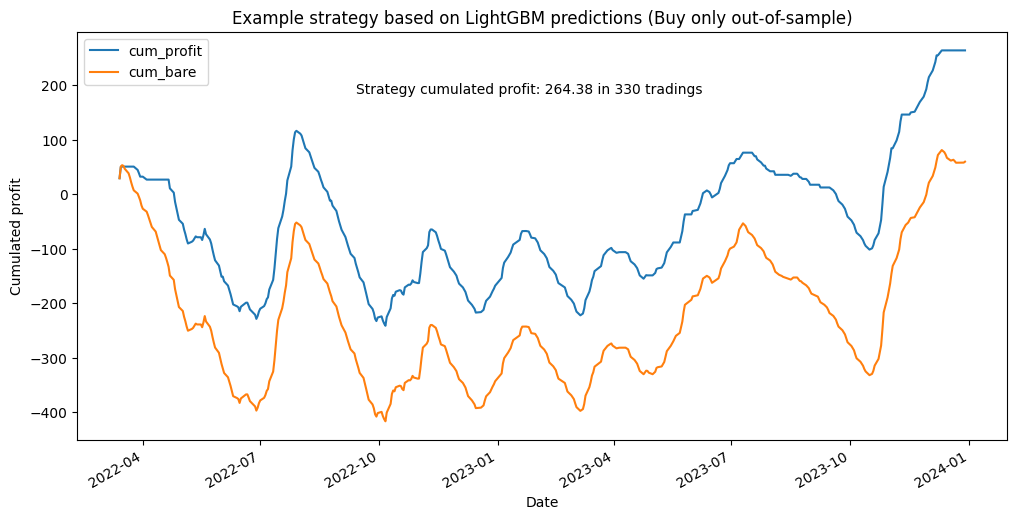

In [23]:
plot_strategy(strategy_df, "LightGBM", "(Buy only out-of-sample)")

In [24]:
compare_df["cum_profit_out"] = strategy_df["cum_profit"].values

## LightGBM with data from MC simulation and additional features

In [25]:
new_df = pd.concat(
    (
        ml_df[
            [
                "UNDERLYING_LAST",
                "STRIKE",
                "C_LAST",
                "C_BID",
                "C_ASK",
                "C_IV",
                "C_VOLUME",
                "diff",
            ]
        ],
        wk_df.drop(["last_quote", "strike", "r"], axis=1),
    ),
    axis=1,
)

In [26]:
# Add some features
new_df["iqr"] = new_df["exp_price_q3"] - new_df["exp_price_q1"]
new_df["diff_call"] = new_df["exp_call_price"] - new_df["C_LAST"]
new_df["exp_price_var"] = np.power(new_df["exp_price_std"], 2)
new_df["exp_profit"] = new_df["exp_price"] - (new_df["STRIKE"] + new_df["C_LAST"])

### Split dataset

In [27]:
X_train, X_test, y_train, y_test = train_test_split(
    new_df,
    target.values.flatten(),
    test_size=TEST_SIZE,
    random_state=1968,
    shuffle=False,
)

### Hyper-parameters tuning using Optuna

In [28]:
# Set hash seed for reproducibility
hashseed = os.getenv("PYTHONHASHSEED")
os.environ["PYTHONHASHSEED"] = "0"
study = optuna.create_study(
    direction="maximize",
    sampler=optuna.samplers.TPESampler(seed=1968, n_startup_trials=0),
)
study.optimize(
    lambda trial: objective_lightgbm(trial, X_train, y_train, METRIC),
    n_trials=150,
    timeout=TIMEOUT * 2,
)

print("Number of finished trials: {}".format(len(study.trials)))

print("Best trial:")
trial = study.best_trial

print("  Value: {}".format(trial.value))

print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))
# Restore hash seed
if hashseed is not None:
    os.environ["PYTHONHASHSEED"] = hashseed

[I 2024-02-14 20:07:20,231] A new study created in memory with name: no-name-7cbfc562-ae13-4cbb-8461-7ed9bba02dd5
[I 2024-02-14 20:07:23,030] Trial 0 finished with value: 0.7083607200792824 and parameters: {'lambda_l1': 7.404718208036244e-05, 'lambda_l2': 0.0017734167489736213, 'num_leaves': 242, 'feature_fraction': 0.5157500776564684, 'bagging_fraction': 0.9559495145396355, 'bagging_freq': 5, 'min_child_samples': 30}. Best is trial 0 with value: 0.7083607200792824.
[I 2024-02-14 20:07:24,540] Trial 1 finished with value: 0.7032472909320184 and parameters: {'lambda_l1': 4.4622527237644664e-05, 'lambda_l2': 0.001522988392116389, 'num_leaves': 243, 'feature_fraction': 0.4941731326532077, 'bagging_fraction': 0.9532107188094674, 'bagging_freq': 5, 'min_child_samples': 26}. Best is trial 0 with value: 0.7083607200792824.
[I 2024-02-14 20:07:24,870] Trial 2 finished with value: 0.5958966864174438 and parameters: {'lambda_l1': 0.9174571299820613, 'lambda_l2': 7.370748490098066, 'num_leaves': 

Number of finished trials: 150
Best trial:
  Value: 0.7441332575703905
  Params: 
    lambda_l1: 0.0023732870777104765
    lambda_l2: 1.1546784149198083e-07
    num_leaves: 177
    feature_fraction: 0.44008063904890526
    bagging_fraction: 0.8575201952689782
    bagging_freq: 7
    min_child_samples: 7


In [29]:
pipe = Pipeline(
    [
        ("imputer", SimpleImputer(strategy="constant", fill_value=0.0)),
        (
            "clf",
            lgb.LGBMClassifier(
                **study.best_params
                | {
                    "random_state": 1968,
                    "objective": "binary",
                    "metric": "average_precision",
                    "verbosity": -1,
                    "boosting_type": "gbdt",
                }
            ),
        ),
    ]
)

In [30]:
# Fit the tuned model
pipe.fit(X_train, y_train)

Pipeline(steps=[('imputer', SimpleImputer(fill_value=0.0, strategy='constant')),
                ('clf',
                 LGBMClassifier(bagging_fraction=0.8575201952689782,
                                bagging_freq=7,
                                feature_fraction=0.44008063904890526,
                                lambda_l1=0.0023732870777104765,
                                lambda_l2=1.1546784149198083e-07,
                                metric='average_precision', min_child_samples=7,
                                num_leaves=177, objective='binary',
                                random_state=1968, verbosity=-1))])

In [31]:
# In-sample score
pipe.score(X_train, y_train)

1.0

In [32]:
# Best threshold given a 5% of maximum false positive rate
threshold = select_threshold(
    pipe.predict_proba(X_train)[:, 1], y_train, fpr_max=FPR_MAX
)
print(f"Best threshold: {threshold:.2f}")

Best threshold: 0.96


In [33]:
# Use the threshold to make predictions
predictions = np.where(pipe.predict_proba(X_test)[:, 1] >= threshold, 1, 0)

In [34]:
pipe.score(X_test, y_test)

0.475

              precision    recall  f1-score   support

           0       0.72      0.42      0.53       236
           1       0.48      0.76      0.59       164

    accuracy                           0.56       400
   macro avg       0.60      0.59      0.56       400
weighted avg       0.62      0.56      0.56       400



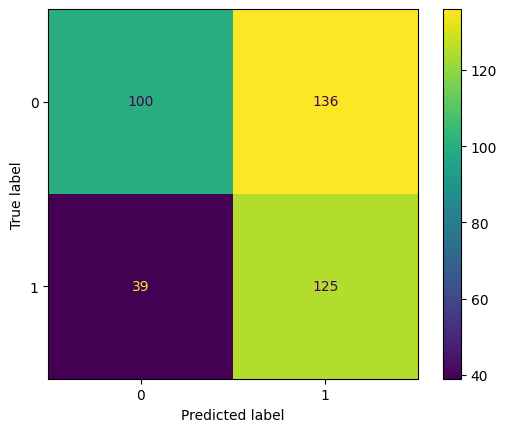

In [35]:
display_report(y_test, predictions)

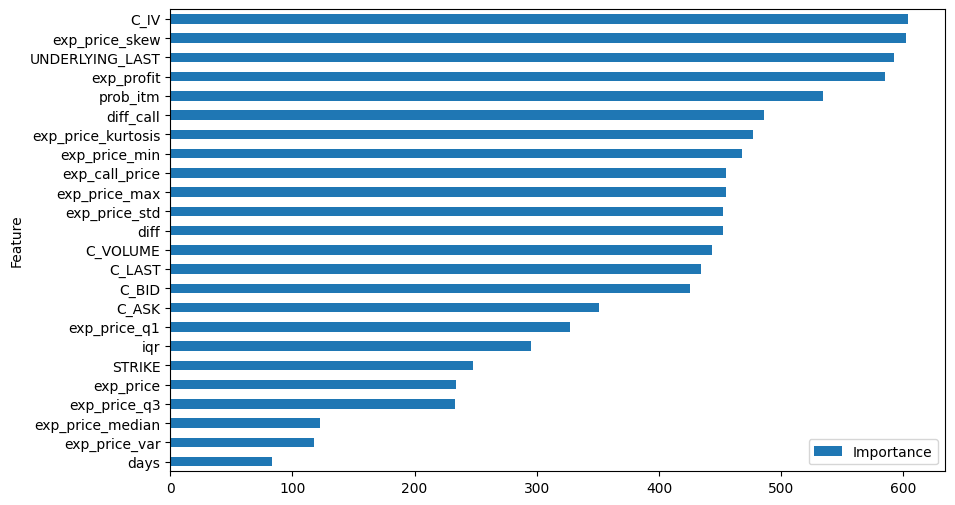

In [36]:
coefficients = pipe.named_steps["clf"].feature_importances_
columns = new_df.columns
plot_feature_imp(coefficients, columns)

In [37]:
compare_df["mmar_rf_pred_out"] = predictions

### Backtesting

In [38]:
strategy_df = backtest_strategy(predictions, X_test, spy, ml_df)

In [39]:
strategy_df

,strategy,strike,call_price,exp_date,final_price,profit,bare,cum_profit,cum_bare
Date,,,,,,,,,
2022-03-14,1,416.0,11.15,2022-04-04,456.799988,29.649988,29.649988,29.649988,29.649988
2022-03-15,0,426.0,9.43,2022-04-04,456.799988,0.000000,21.369988,29.649988,51.019976
2022-03-16,0,436.0,7.90,2022-04-06,446.519989,0.000000,2.619989,29.649988,53.639965
2022-03-17,0,440.0,7.72,2022-04-06,446.519989,0.000000,-1.200011,29.649988,52.439954
2022-03-18,0,444.0,8.93,2022-04-08,447.570007,0.000000,-5.359993,29.649988,47.079961
...,...,...,...,...,...,...,...,...,...
2023-12-21,0,473.0,6.07,2024-01-12,476.679993,0.000000,-2.390007,372.499976,61.179850
2023-12-22,0,474.0,5.70,2024-01-12,476.679993,0.000000,-3.020007,372.499976,58.159843
2023-12-27,0,476.0,6.19,2024-01-19,482.429993,0.000000,0.239993,372.499976,58.399835


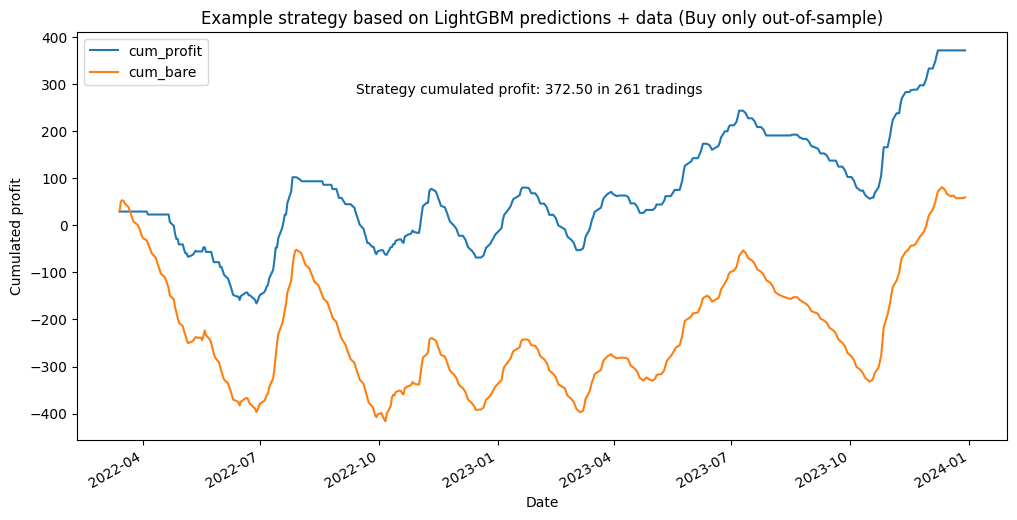

In [40]:
plot_strategy(strategy_df, "LightGBM", "+ data (Buy only out-of-sample)")

In [41]:
compare_df["mmar_cum_profit_out"] = strategy_df["cum_profit"].values
compare_df["mmar_cum_bare_out"] = strategy_df["cum_bare"].values

## Compare the two predictions

In [42]:
mask_out = (compare_df["bare_rf_pred_out"] - compare_df["mmar_rf_pred_out"]).astype(
    bool
)

In [43]:
# Compare out of sample preds
compare_df[mask_out]

,bare_rf_pred_out,cum_profit_out,mmar_rf_pred_out,mmar_cum_profit_out,mmar_cum_bare_out
1,1,51.019976,0,29.649988,51.019976
10,1,44.969976,0,29.649988,1.459961
11,1,39.059976,0,29.649988,-4.450039
12,1,32.559976,0,29.649988,-10.950039
15,1,27.149976,0,29.649988,-31.730039
...,...,...,...,...,...
379,1,160.549937,0,289.130015,-33.160074
381,1,179.439910,0,298.240001,-14.270101
385,1,227.529885,0,334.009983,33.819874
388,0,255.269880,1,372.499976,72.309867


In [44]:
compare_df[mask_out].shape

(109, 5)

In [45]:
compare_df.sum(axis=0)

bare_rf_pred_out         330.000000
cum_profit_out        -20972.618215
mmar_rf_pred_out         261.000000
mmar_cum_profit_out    24950.664796
mmar_cum_bare_out     -89134.646364
dtype: float64

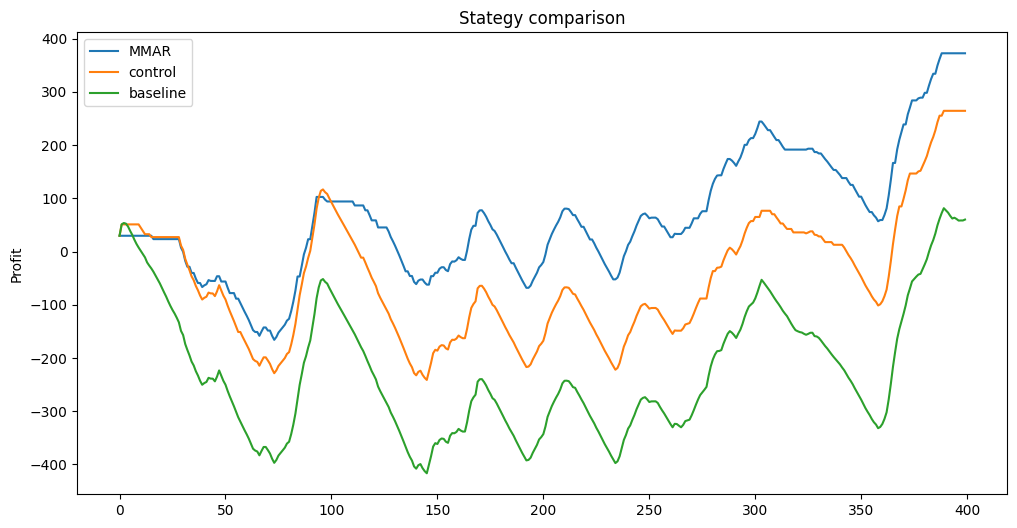

In [47]:
compare_df[["mmar_cum_profit_out", "cum_profit_out", "mmar_cum_bare_out"]].rename(
    {
        "mmar_cum_profit_out": "MMAR",
        "cum_profit_out": "control",
        "mmar_cum_bare_out": "baseline",
    },
    axis=1,
).plot(figsize=(12, 6), title="Stategy comparison", ylabel="Profit")
plt.show()